<a href="https://colab.research.google.com/github/velamalaappu/icc-automatic-question-answer-system-analysis./blob/main/Automatic_Question_Answer_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automated Question Answer System**

# **Project Introduction**

The Indian education landscape has been undergoing rapid changes for the past 10 years owing to
the advancement of web-based learning services, specifically, eLearning platforms.

Most online education institutes today treat all students in the same class/batch/cohort (referred to as
“group” hereinafter) the same. Institutional uniformity works quite well for machines but humans are
made up of different and often contradictory components!

We believe that the model of allowing all students to learn at the same pace with the same level of
interest is quite detrimental to the quality of education. This model is testing the capabilities of
students by forcing them to work together in groups at the same pace, regardless of each individual's
ability and the interests of the work.

The reality could not be farther from the truth. The reason we see a wide variation in the group
performance is owing to this thought process.

In a system based on Competency Based Learning (referred to as “CBL” going forward), the group is
accepted as a set of diverse individuals who may come with some common traits but also recognizes
their different educational backgrounds, life & work experiences and learning styles.

Competency-based learning is an approach to education that focuses on the student’s demonstration
of desired learning outcomes as central to the learning process. A key characteristic of
competency-based learning is its focus on mastery. In other learning models, students are exposed to
content–whether skills or concepts–over time, and success is measured on a summative basis. In a
competency-based learning system, students are not allowed to continue until they have
demonstrated mastery of the identified competencies (i.e., the desired learning outcomes to be
demonstrated).

It is quite common to see students get stuck, fall behind, give up & in extreme cases – drop out of the
program in the traditional model of education. A standard experience for a student in this model is
“failing” and then having to repeat the class/subject/year till they are able to achieve a passing grade.
This causes the student to lose interest in addition to social embarrassment. The result is a student
who is now trying to “pass” by rote memorization and doing the bare minimum for the passing.

While assessments based on rubrics are a cornerstone for the CBL system as well – they serve the
purpose of reinforcing the concepts, and to show the student & the instructor(s) how well understood
are each of the concepts and their application; rather than making just a judgment of passing and
failing.

In this light, to be able to cater to a large pool of students to enable seamless learning, we envision an
automated doubt resolution system. In the era of advancing AI technology, most of the doubts can be
resolved via deep learning techniques. The AI system in place can understand the context of the
question and can provide relevant answers to the questions.

# **Problem Statement**

We will solve the above-mentioned challenge by applying deep learning algorithms to textual data.
The solution to this problem can be obtained through Extractive Question Answering wherein we can
extract an answer from a text given the question.

# **Question Answering Bot**

## **Loading the Data**

I work with the Babi Data Set from Facebook Research.

Full Details: https://research.fb.com/downloads/babi/

Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush, "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks", http://arxiv.org/abs/1502.05698

In [28]:
import keras
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM, GRU
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

from functools import reduce
import tarfile
import numpy as np
import re

import IPython
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import pickle
import numpy as np

In [32]:
with open("/content/drive/MyDrive/Colab Notebooks/question answer system/train_qa.txt", "rb") as fp:   # Unpickling, read-binary
    train_data =  pickle.load(fp)

In [33]:
with open("/content/drive/MyDrive/Colab Notebooks/question answer system/test_qa.txt", "rb") as fp:   # Unpickling
    test_data =  pickle.load(fp)

## **Exploring the Format of the Data**

In [ ]:
type(test_data)

list

In [ ]:
type(train_data)

list

In [ ]:
len(test_data)

1000

In [ ]:
len(train_data)

10000

In [ ]:
train_data[50]

(['Mary',
  'went',
  'back',
  'to',
  'the',
  'bathroom',
  '.',
  'Daniel',
  'went',
  'to',
  'the',
  'office',
  '.'],
 ['Is', 'Mary', 'in', 'the', 'bathroom', '?'],
 'yes')

In [ ]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [ ]:
text=''
print('Story:')
for sent in train_data[99]:
    if sent!='yes' and sent!='no':
        for word in sent:
            if (word!='.'):
                if (word!='?'):
                    text+= word + ' '
                else:
                    print()
                    print('Question:', text[:-1]+word)
                    print()
            else:
                print(text[:-1]+word)
                text=''
    else:
        print('Answer:', sent)

Story:
Daniel grabbed the apple there.
Daniel went to the bedroom.
John moved to the garden.
Sandra journeyed to the office.
Daniel put down the apple.
Mary went to the bedroom.
Mary grabbed the apple there.
Sandra went back to the garden.
Mary went to the kitchen.
Daniel went to the office.

Question: Is Mary in the garden?

Answer: no


In [ ]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [ ]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [ ]:
train_data[0][2]

'no'

# **Setting up Vocabulary of All Words**

In [ ]:
# Create a set that holds the vocab words
vocab = set()

In [ ]:
all_data = test_data + train_data

In [ ]:
len(all_data)

11000

In [ ]:
set(train_data[0][0]) # story component

{'.',
 'Mary',
 'Sandra',
 'bathroom',
 'bedroom',
 'journeyed',
 'moved',
 'the',
 'to'}

In [ ]:
for story, question , answer in all_data:
    # In case you don't know what a union of sets is:
    # https://www.programiz.com/python-programming/methods/set/union
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

adding the answer possibilities

In [ ]:
vocab.add('no')
vocab.add('yes')

In [ ]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [ ]:
vocab_len = len(vocab) + 1 

In [ ]:
vocab_len

38

In [ ]:
max_story_len = max([len(data[0]) for data in all_data])


In [ ]:
max_story_len

156

In [ ]:
max_question_len = max([len(data[1]) for data in all_data])

In [ ]:
max_question_len

6

# **Vectorizing the Data**

In [ ]:
# Reserve 0 for pad_sequences
vocab_size = len(vocab) + 1

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# integer encode sequences of words
tokenizer = Tokenizer(filters=[])   # provide empty list for filter out
tokenizer.fit_on_texts(vocab)

In [ ]:
tokenizer.word_index

{'.': 10,
 '?': 24,
 'apple': 3,
 'back': 6,
 'bathroom': 8,
 'bedroom': 2,
 'daniel': 18,
 'discarded': 1,
 'down': 36,
 'dropped': 31,
 'football': 9,
 'garden': 19,
 'got': 4,
 'grabbed': 14,
 'hallway': 13,
 'in': 11,
 'is': 25,
 'john': 30,
 'journeyed': 21,
 'kitchen': 23,
 'left': 34,
 'mary': 27,
 'milk': 17,
 'moved': 32,
 'no': 5,
 'office': 22,
 'picked': 35,
 'put': 26,
 'sandra': 20,
 'the': 37,
 'there': 33,
 'to': 28,
 'took': 29,
 'travelled': 7,
 'up': 12,
 'went': 16,
 'yes': 15}

In [ ]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [ ]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [ ]:
len(train_story_text)

10000

In [ ]:
len(train_story_seq)

10000

In [ ]:
# word_index = tokenizer.word_index

## **Functionalize Vectorization**

In [ ]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    '''
    INPUT: 
    
    data: consisting of Stories,Queries,and Answers
    word_index: word index dictionary from tokenizer
    max_story_len: the length of the longest story (used for pad_sequences function)
    max_question_len: length of the longest question (used for pad_sequences function)


    OUTPUT:
    
    Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
    answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
    output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.
    
    Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)
    '''
    
    
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
    
    
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(vocab_size)  # this includes +1 for padding
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [ ]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [ ]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [ ]:
# padding mode 'pre'
inputs_test

array([[ 0,  0,  0, ..., 37,  2, 10],
       [ 0,  0,  0, ..., 37, 19, 10],
       [ 0,  0,  0, ..., 37, 19, 10],
       ...,
       [ 0,  0,  0, ..., 37,  3, 10],
       [ 0,  0,  0, ..., 37, 19, 10],
       [ 0,  0,  0, ...,  3, 33, 10]], dtype=int32)

In [ ]:
queries_test

array([[25, 30, 11, 37, 23, 24],
       [25, 30, 11, 37, 23, 24],
       [25, 30, 11, 37, 19, 24],
       ...,
       [25, 27, 11, 37,  2, 24],
       [25, 20, 11, 37, 19, 24],
       [25, 27, 11, 37, 19, 24]], dtype=int32)

In [ ]:
# one-hot vectors of size V vocabulary for Yes / No
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Equal proportion of Yes / No answers
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0., 503.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0., 497.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [ ]:
tokenizer.word_index['yes']

15

In [ ]:
tokenizer.word_index['no']

5

# **Creating the Model**

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input, Activation, Dense, Permute, Dropout
from tensorflow.keras.layers import add, dot, concatenate
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop

### **Placeholders for Inputs**

Recall we technically have two inputs, stories and questions. So we need to use placeholders. Input() is used to instantiate a Keras tensor.



In [ ]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

# **Building the Networks**

### **Encoders**

### **Input Encoder m**

In [ ]:
embedding_dim = 128

# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim= embedding_dim))
input_encoder_m.add(Dropout(0.3))

# This encoder will output:
# (samples, story_maxlen, embedding_dim)

### **Input Encoder c**

In [ ]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

### **Question Encoder**

In [ ]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embedding_dim,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

### **Encode the Sequences**

In [ ]:
# encode input sequence and questions (which are indices) to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

Use dot product to compute the match between first input vector seq and the query



In [ ]:
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

Add this match matrix with the second input vector sequence

In [ ]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

## **Concatenate**

In [ ]:
# concatenate the match matrix with the question vector sequence
# (samples, query_maxlen, story_maxlen + embedding_dim)
answer = concatenate([response, question_encoded])

In [ ]:
answer

<KerasTensor: shape=(None, 6, 284) dtype=float32 (created by layer 'concatenate')>

In [ ]:
# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)  # shape (samples, 32)

In [ ]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

In [ ]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)


In [ ]:
# build the final model
model = Model([input_sequence, question], answer)
optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 128)    4864        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 128)       4864        ['input_2[0][0]']                
                                                                                              

In [ ]:
import math
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

initial_learning_rate = 0.01
epochs = 120
decay = initial_learning_rate / epochs

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 20
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

learning_rate = LearningRateScheduler(lr_step_decay, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.66, patience=5, min_lr=0.0001, verbose=1) 

In [ ]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=256,epochs=120,validation_data=([inputs_test, queries_test], answers_test)) 

Epoch 1/120
40/40 [==============================] - 9s 141ms/step - loss: 0.8831 - accuracy: 0.4845 - val_loss: 0.7002 - val_accuracy: 0.5030
Epoch 2/120
40/40 [==============================] - 5s 128ms/step - loss: 0.7070 - accuracy: 0.5011 - val_loss: 0.6935 - val_accuracy: 0.4970
Epoch 3/120
40/40 [==============================] - 5s 119ms/step - loss: 0.7046 - accuracy: 0.5025 - val_loss: 0.7645 - val_accuracy: 0.4970
Epoch 4/120
40/40 [==============================] - 5s 128ms/step - loss: 0.7010 - accuracy: 0.5081 - val_loss: 0.6943 - val_accuracy: 0.4970
Epoch 5/120
40/40 [==============================] - 5s 121ms/step - loss: 0.6981 - accuracy: 0.4995 - val_loss: 0.7125 - val_accuracy: 0.5030
Epoch 6/120
40/40 [==============================] - 5s 121ms/step - loss: 0.6974 - accuracy: 0.4986 - val_loss: 0.7585 - val_accuracy: 0.5030
Epoch 7/120
40/40 [==============================] - 6s 159ms/step - loss: 0.6940 - accuracy: 0.5052 - val_loss: 0.6883 - val_accuracy: 0.5850

## **Saving the Model**

In [ ]:
filename = 'chatbot_120_epochs_9710.h5'
model.save(filename)

## **Evaluating the Model**

### **Plotting Out Training History**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


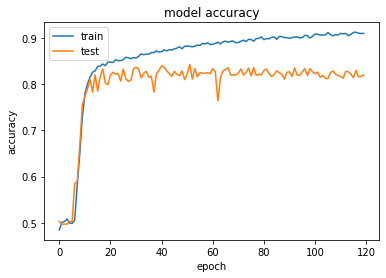

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy.png', dpi=180, facecolor='white')
plt.show()

### **Evaluating on Given Test Set**

In [ ]:
#model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))

In [ ]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [ ]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [ ]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [ ]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [ ]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.9971731


## **Writing Your Own Stories and Questions**

Remember you can only use words from the existing vocab

In [ ]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [ ]:
# Note the whitespace of the periods
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [ ]:
my_question = "Is the football in the garden ?"

In [ ]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [ ]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [ ]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [ ]:
pred_results = model.predict(([ my_story, my_ques]))

In [ ]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.99999034


## **test**

In [ ]:
my_story = "Sandra grabbed Mary in the kitchen . Sandra picked the apple in the garden . John got back in the office . Mary got the milk . Daniel discarded the apple ."
my_question = "Is apple in the garden ?"
mydata = [(my_story.split(),my_question.split(),'yes')]
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [ ]:
pred_results = model.predict(([ my_story, my_ques]))

In [ ]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.9853114


In [ ]:
my_story = 'Daniel grabbed the apple there . Daniel went to the bedroom . John moved to the garden . Sandra journeyed to the office . Daniel put down the apple . Mary went to the bedroom . Mary grabbed the apple there . Sandra went back to the garden . Mary went to the kitchen . Daniel went to the office .'
my_question = "Is Mary in the bedroom ?"
mydata = [(my_story.split(),my_question.split(),'no')]
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [ ]:
pred_results = model.predict(([ my_story, my_ques]))

In [ ]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.8895055


# **Finding the closest question and answer it**

# **Data set**

There are three question files, one for each year of students: S08, S09, and S10, as well as 690,000 words worth of cleaned text from Wikipedia that was used to generate the questions.

The "questionanswerpairs.txt" files contain both the questions and answers. The columns in this file are as follows:

ArticleTitle is the name of the Wikipedia article from which questions and answers initially came.

Question is the question.

Answer is the answer.

Difficulty From Questioner is the prescribed difficulty rating for the question as given to the question-writer.

Difficulty From Answerer is a difficulty rating assigned by the individual who evaluated and answered the question, which may differ from the difficulty in field 4.

ArticleFile is the name of the file with the relevant article
Questions that were judged to be poor were discarded from this data set.

There are frequently multiple lines with the same question, which appear if those questions were answered by multiple individuals.

In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM, GRU
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

from functools import reduce
import tarfile
import numpy as np
import re

import IPython
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Automated Question Answer System/S08_question_answer_pairs.txt', sep='\t')
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Automated Question Answer System/S09_question_answer_pairs.txt', sep='\t')
df3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Automated Question Answer System/S10_question_answer_pairs.txt', sep='\t', encoding = 'ISO-8859-1')

# **Preprocessing data**

In [4]:
df1.head(20)

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,S08_set3_a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,S08_set3_a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,S08_set3_a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,S08_set3_a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,S08_set3_a4
5,Abraham_Lincoln,Did his mother die of pneumonia?,No.,easy,easy,S08_set3_a4
6,Abraham_Lincoln,How many long was Lincoln's formal education?,18 months,medium,easy,S08_set3_a4
7,Abraham_Lincoln,How many long was Lincoln's formal education?,18 months.,medium,medium,S08_set3_a4
8,Abraham_Lincoln,When did Lincoln begin his political career?,1832,medium,easy,S08_set3_a4
9,Abraham_Lincoln,When did Lincoln begin his political career?,1832.,medium,medium,S08_set3_a4


In [5]:
all_data = df1.append([df2, df3])
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3998 entries, 0 to 1457
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ArticleTitle              3998 non-null   object
 1   Question                  3961 non-null   object
 2   Answer                    3422 non-null   object
 3   DifficultyFromQuestioner  3043 non-null   object
 4   DifficultyFromAnswerer    3418 non-null   object
 5   ArticleFile               3996 non-null   object
dtypes: object(6)
memory usage: 218.6+ KB


In [6]:
all_data['Question'] = all_data['ArticleTitle'].str.replace('_', ' ') + ' ' + all_data['Question']
all_data = all_data[['Question', 'Answer']]
all_data.shape

(3998, 2)

In [7]:
all_data.head(10)

,Question,Answer
0,Abraham Lincoln Was Abraham Lincoln the sixtee...,yes
1,Abraham Lincoln Was Abraham Lincoln the sixtee...,Yes.
2,Abraham Lincoln Did Lincoln sign the National ...,yes
3,Abraham Lincoln Did Lincoln sign the National ...,Yes.
4,Abraham Lincoln Did his mother die of pneumonia?,no
5,Abraham Lincoln Did his mother die of pneumonia?,No.
6,Abraham Lincoln How many long was Lincoln's fo...,18 months
7,Abraham Lincoln How many long was Lincoln's fo...,18 months.
8,Abraham Lincoln When did Lincoln begin his pol...,1832
9,Abraham Lincoln When did Lincoln begin his pol...,1832.


In [8]:
all_data = all_data.drop_duplicates(subset='Question')
all_data.head(10)

,Question,Answer
0,Abraham Lincoln Was Abraham Lincoln the sixtee...,yes
2,Abraham Lincoln Did Lincoln sign the National ...,yes
4,Abraham Lincoln Did his mother die of pneumonia?,no
6,Abraham Lincoln How many long was Lincoln's fo...,18 months
8,Abraham Lincoln When did Lincoln begin his pol...,1832
10,Abraham Lincoln What did The Legal Tender Act ...,"the United States Note, the first paper curren..."
12,Abraham Lincoln Who suggested Lincoln grow a b...,11-year-old Grace Bedell
14,Abraham Lincoln When did the Gettysburg addres...,1776
16,Abraham Lincoln Did Lincoln beat John C. Breck...,yes
18,Abraham Lincoln Was Abraham Lincoln the first ...,No


In [9]:
all_data.shape

(2461, 2)

In [10]:
all_data = all_data.dropna()
all_data.shape

(2188, 2)

In [18]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def my_tokenizer(doc):
    words = word_tokenize(doc)
    
    pos_tags = pos_tag(words)
    
    non_stopwords = [w for w in pos_tags if not w[0].lower() in stopwords_list]
    
    non_punctuation = [w for w in non_stopwords if not w[0] in string.punctuation]
    
    lemmas = []
    for w in non_punctuation:
        if w[1].startswith('J'):
            pos = wordnet.ADJ
        elif w[1].startswith('V'):
            pos = wordnet.VERB
        elif w[1].startswith('N'):
            pos = wordnet.NOUN
        elif w[1].startswith('R'):
            pos = wordnet.ADV
        else:
            pos = wordnet.NOUN
        
        lemmas.append(lemmatizer.lemmatize(w[0], pos))

    return lemmas

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=20000,
                                   min_df=1, use_idf=True, ngram_range=(1,1))
# note: minimum of 2 occurrences, rather than 0.2 (20% of all documents)

tfidf_matrix = tfidf_vectorizer.fit_transform(tuple(all_data['Question']))

print(tfidf_matrix.shape)

(2188, 4081)


In [23]:
from sklearn.metrics.pairwise import cosine_similarity
def ask_question(question):
    query_vect = tfidf_vectorizer.transform([question])
    similarity = cosine_similarity(query_vect, tfidf_matrix)
    max_similarity = np.argmax(similarity, axis=None)
    
    print('Your question:', question)
    print('Closest question found:', all_data.iloc[max_similarity]['Question'])
    print('Similarity: {:.2%}'.format(similarity[0, max_similarity]))
    print('Answer:', all_data.iloc[max_similarity]['Answer'])

After running the code,we need to ask question if we get  very similar to closest question found then the result will be **YES**. Or else result show **NO**

In [24]:
ask_question('When Abraham Lincoln started his political career')

Your question: When Abraham Lincoln started his political career
Closest question found: Abraham Lincoln When did Lincoln begin his political career?
Similarity: 87.84%
Answer: 1832


In [25]:
ask_question(' Was Abraham Lincoln the sixteenth President of the United States?')

Your question:  Was Abraham Lincoln the sixteenth President of the United States?
Closest question found: Abraham Lincoln Was Abraham Lincoln the sixteenth President of the United States?
Similarity: 94.43%
Answer: yes


In [26]:
ask_question('Can whales fly')

Your question: Can whales fly
Closest question found: Otter Do sea otters have a layer of fat like whales?
Similarity: 29.17%
Answer: No


In [27]:
ask_question('Who was the third president of the United States')

Your question: Who was the third president of the United States
Closest question found: Calvin Coolidge Was Coolidge the thirteenth President of the United States?
Similarity: 49.61%
Answer: No


# **Scope of project**

A. The topic model should be able to identify/extract important topics.

B. The topic model would be built on the corpus of Data Science documents.

C. The topic model should yield the most relevant and stable topics measured through the
perplexity score.

D. Once the relevant documents have been retrieved, the extractive question answering
model would generate the answer for the question.

E. The entire dual-model pipeline would be deployed in AWS/GCP/Azure

F. The dual-model pipeline must be accessible via a web application(Streamlit) for demo
purpose.

## **CONCLUSION**

In this we can get the results as The model is trained very quickly over 120 epochs using RMSprop and lr = 0.01. Other hyperparameters: Embedding size of 128, batch size of 256. Accuracy on unseen test data reaches over 97%.Hence We get accurate results of extracting an answer from a text given a question. The text would essentially be the group of documents that have the highest concentration of the topic closest to the asked question and also solve the above-mentioned challenge by applying deep learning algorithms to textual data.The solution to this problem can be obtained through Extractive Question Answering wherein we can extract an answer from a text given the question.